In [1]:
import matplotlib.pyplot as plt 

from mlxtend.data import loadlocal_mnist
import platform

In [2]:
X_train, y_train = loadlocal_mnist(
    images_path='data/train-images-idx3-ubyte', 
    labels_path='data/train-labels-idx1-ubyte')
X_test, y_test = loadlocal_mnist(
    images_path='data/t10k-images-idx3-ubyte', 
    labels_path='data/t10k-labels-idx1-ubyte')

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 64         # number of data points in each batch
N_EPOCHS = 50           # times to run the model on complete data
INPUT_DIM = 28 * 28     # size of each input
HIDDEN_DIM = 100        # hidden dimension
LATENT_DIM = 50         # latent vector dimension
N_CLASSES = 10          # number of classes in the data
lr = 1e-3               # learning rate

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
X_train = torch.tensor(X_train / 255, dtype=torch.float64)
Y_train = torch.tensor(y_train).reshape(X_train.shape[0], 1)
X_test = torch.tensor(X_test / 255, dtype=torch.float64)
Y_test = torch.tensor(y_test).reshape(X_test.shape[0], 1)

In [7]:
C_train = torch.zeros(Y_train.shape[0], 10).type(torch.float64)
C_train.scatter_(1, Y_train.type(torch.int64), torch.ones(Y_train.shape[0], 1).type(torch.float64))
C_test = torch.zeros(y_test.shape[0], N_CLASSES).type(torch.float64)
C_test.scatter_(1, Y_test.type(torch.int64), torch.ones(Y_test.shape[0], 1).type(torch.float64))

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [8]:
class Encoder(nn.Module):
    ''' This the encoder part of VAE

    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.linear1 = nn.Linear(input_dim + n_classes, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 100)
        self.mu_z = nn.Linear(100, latent_dim)
        self.log_var_z = nn.Linear(100, latent_dim)
    
    def forward(self, x, c):
        out = F.relu(self.linear1(torch.cat([x, c], axis=1)))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        mu_z = self.mu_z(out)
        log_var_z = self.log_var_z(out)
        
        return mu_z, log_var_z

In [9]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE

    '''
    def __init__(self, latent_dim, hidden_dim, output_dim, n_classes):
        '''
        Args:
            latent_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the size of output (in case of MNIST 28 * 28).
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()
        
        self.linear1 = nn.Linear(latent_dim + n_classes, 100)
        self.linear2 = nn.Linear(100, 256)
        self.linear3 = nn.Linear(256, 512)
        self.output = nn.Linear(512, output_dim)
        
    def forward(self, z, c):
        out = F.relu(self.linear1(torch.cat([z, c], axis=1)))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = torch.sigmoid(self.output(out))
        
        return out

In [10]:
enc = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, N_CLASSES).to(device=device, dtype=torch.float64)
dec = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM, N_CLASSES).to(device=device, dtype=torch.float64)

In [11]:
train_dataset = TensorDataset(X_train, C_train)
test_dataset = TensorDataset(X_test, C_test)

train_iter = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [12]:
def loss_fn(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [13]:
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)

In [14]:
train_losses = []
test_losses = []

for ep in range(N_EPOCHS):
    for x, c in train_iter: 
        # Zero grad 
        optimizer.zero_grad()
        
        # Forward 
        mu_z, log_var_z = enc(x.to(device), c.to(device))
        std_z = torch.exp(0.5 * log_var_z)
        
        eps = torch.randn_like(log_var_z)
#         z_samples = mu_z + eps * std_z
        z_samples = eps.mul(std_z).add_(mu_z)
        
        x_out = dec(z_samples, c.to(device))
        
        # Loss 
        loss = loss_fn(x_out, x, mu_z, log_var_z)
        
        # Backward
        loss.backward()
        
        # Update 
        optimizer.step()
    
    with torch.no_grad():
        ## Train
        # Forward 
        mu_z, log_var_z = enc(X_train.to(device), C_train.to(device))
        std_z = torch.exp(0.5 * log_var_z)
        
        eps = torch.randn_like(log_var_z)
        z_samples = eps.mul(std_z).add_(mu_z)
        
        x_out = dec(z_samples, C_train.to(device))
        
        # Loss 
        loss = loss_fn(x_out, X_train, mu_z, log_var_z)
        train_losses.append(loss)
        
        ## Test 
        mu_z, log_var_z = enc(X_test.to(device), C_test.to(device))
        std_z = torch.exp(0.5 * log_var_z)
        
        eps = torch.randn_like(log_var_z)
        z_samples = eps.mul(std_z).add_(mu_z)
        
        x_out = dec(z_samples, C_test.to(device))
        
        # Loss 
        loss = loss_fn(x_out, X_test, mu_z, log_var_z)
        test_losses.append(loss)
        
        print("Epoch [%d / %d] train loss: %f test loss: %f" %(ep + 1, N_EPOCHS, train_losses[-1], test_losses[-1]))

Epoch [1 / 50] train loss: 9341199.658097 test loss: 1552335.180549
Epoch [2 / 50] train loss: 8084559.062026 test loss: 1339494.079119
Epoch [3 / 50] train loss: 7703221.157568 test loss: 1282534.319900
Epoch [4 / 50] train loss: 7245396.015867 test loss: 1208516.999156
Epoch [5 / 50] train loss: 7049699.860088 test loss: 1178736.218510
Epoch [6 / 50] train loss: 6938855.544211 test loss: 1162755.774670
Epoch [7 / 50] train loss: 6933315.514670 test loss: 1164485.543734
Epoch [8 / 50] train loss: 6733168.658798 test loss: 1132240.781978
Epoch [9 / 50] train loss: 6959740.441896 test loss: 1173612.358812
Epoch [10 / 50] train loss: 6764333.411019 test loss: 1141303.132695
Epoch [11 / 50] train loss: 6643490.734986 test loss: 1123004.430280
Epoch [12 / 50] train loss: 6675410.883396 test loss: 1130801.337743
Epoch [13 / 50] train loss: 6636641.090629 test loss: 1124679.978922
Epoch [14 / 50] train loss: 6833274.946274 test loss: 1158320.421417
Epoch [15 / 50] train loss: 6594272.707543 

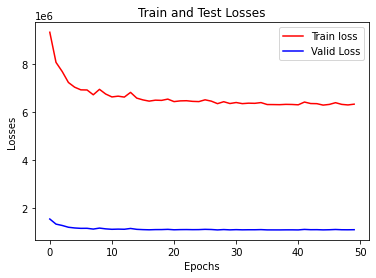

In [15]:
plt.plot(train_losses, "r")
plt.plot(test_losses, "b")
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.title("Train and Test Losses")
plt.legend(["Train loss", "Valid Loss"])
plt.show()

### MSE Loss

In [96]:
prior = torch.distributions.Normal(0, 1)
z = prior.sample((X_test.shape[0], LATENT_DIM)).type(torch.float64)

In [97]:
Y_test

tensor([[7],
        [2],
        [1],
        ...,
        [4],
        [5],
        [6]], dtype=torch.uint8)

In [98]:
C_test

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [105]:
X_out = dec(z.to(device), C_test.to(device))
X_out = X_out.detach()

In [108]:
print("MSE Loss between generated data and test data: ", torch.nn.MSELoss()(X_out, X_test).item())

MSE Loss between generated data and test data:  0.08702786816017133


### Visualize

In [89]:
prior = torch.distributions.Normal(0, 1)
z = prior.sample((100, LATENT_DIM)).type(torch.float64)

In [90]:
Y_result = torch.tensor([i for i in range(10) for j in range(10)]).reshape(100, 1)

In [91]:
C_result = torch.zeros(Y_result.shape[0], N_CLASSES)

In [92]:
C_result.scatter_(1, Y_result, torch.ones(Y_result.shape[0], 1).type(torch.float32))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],


In [93]:
X_out = dec(z.to(device), C_result.to(device))
X_out = X_out.detach().numpy()

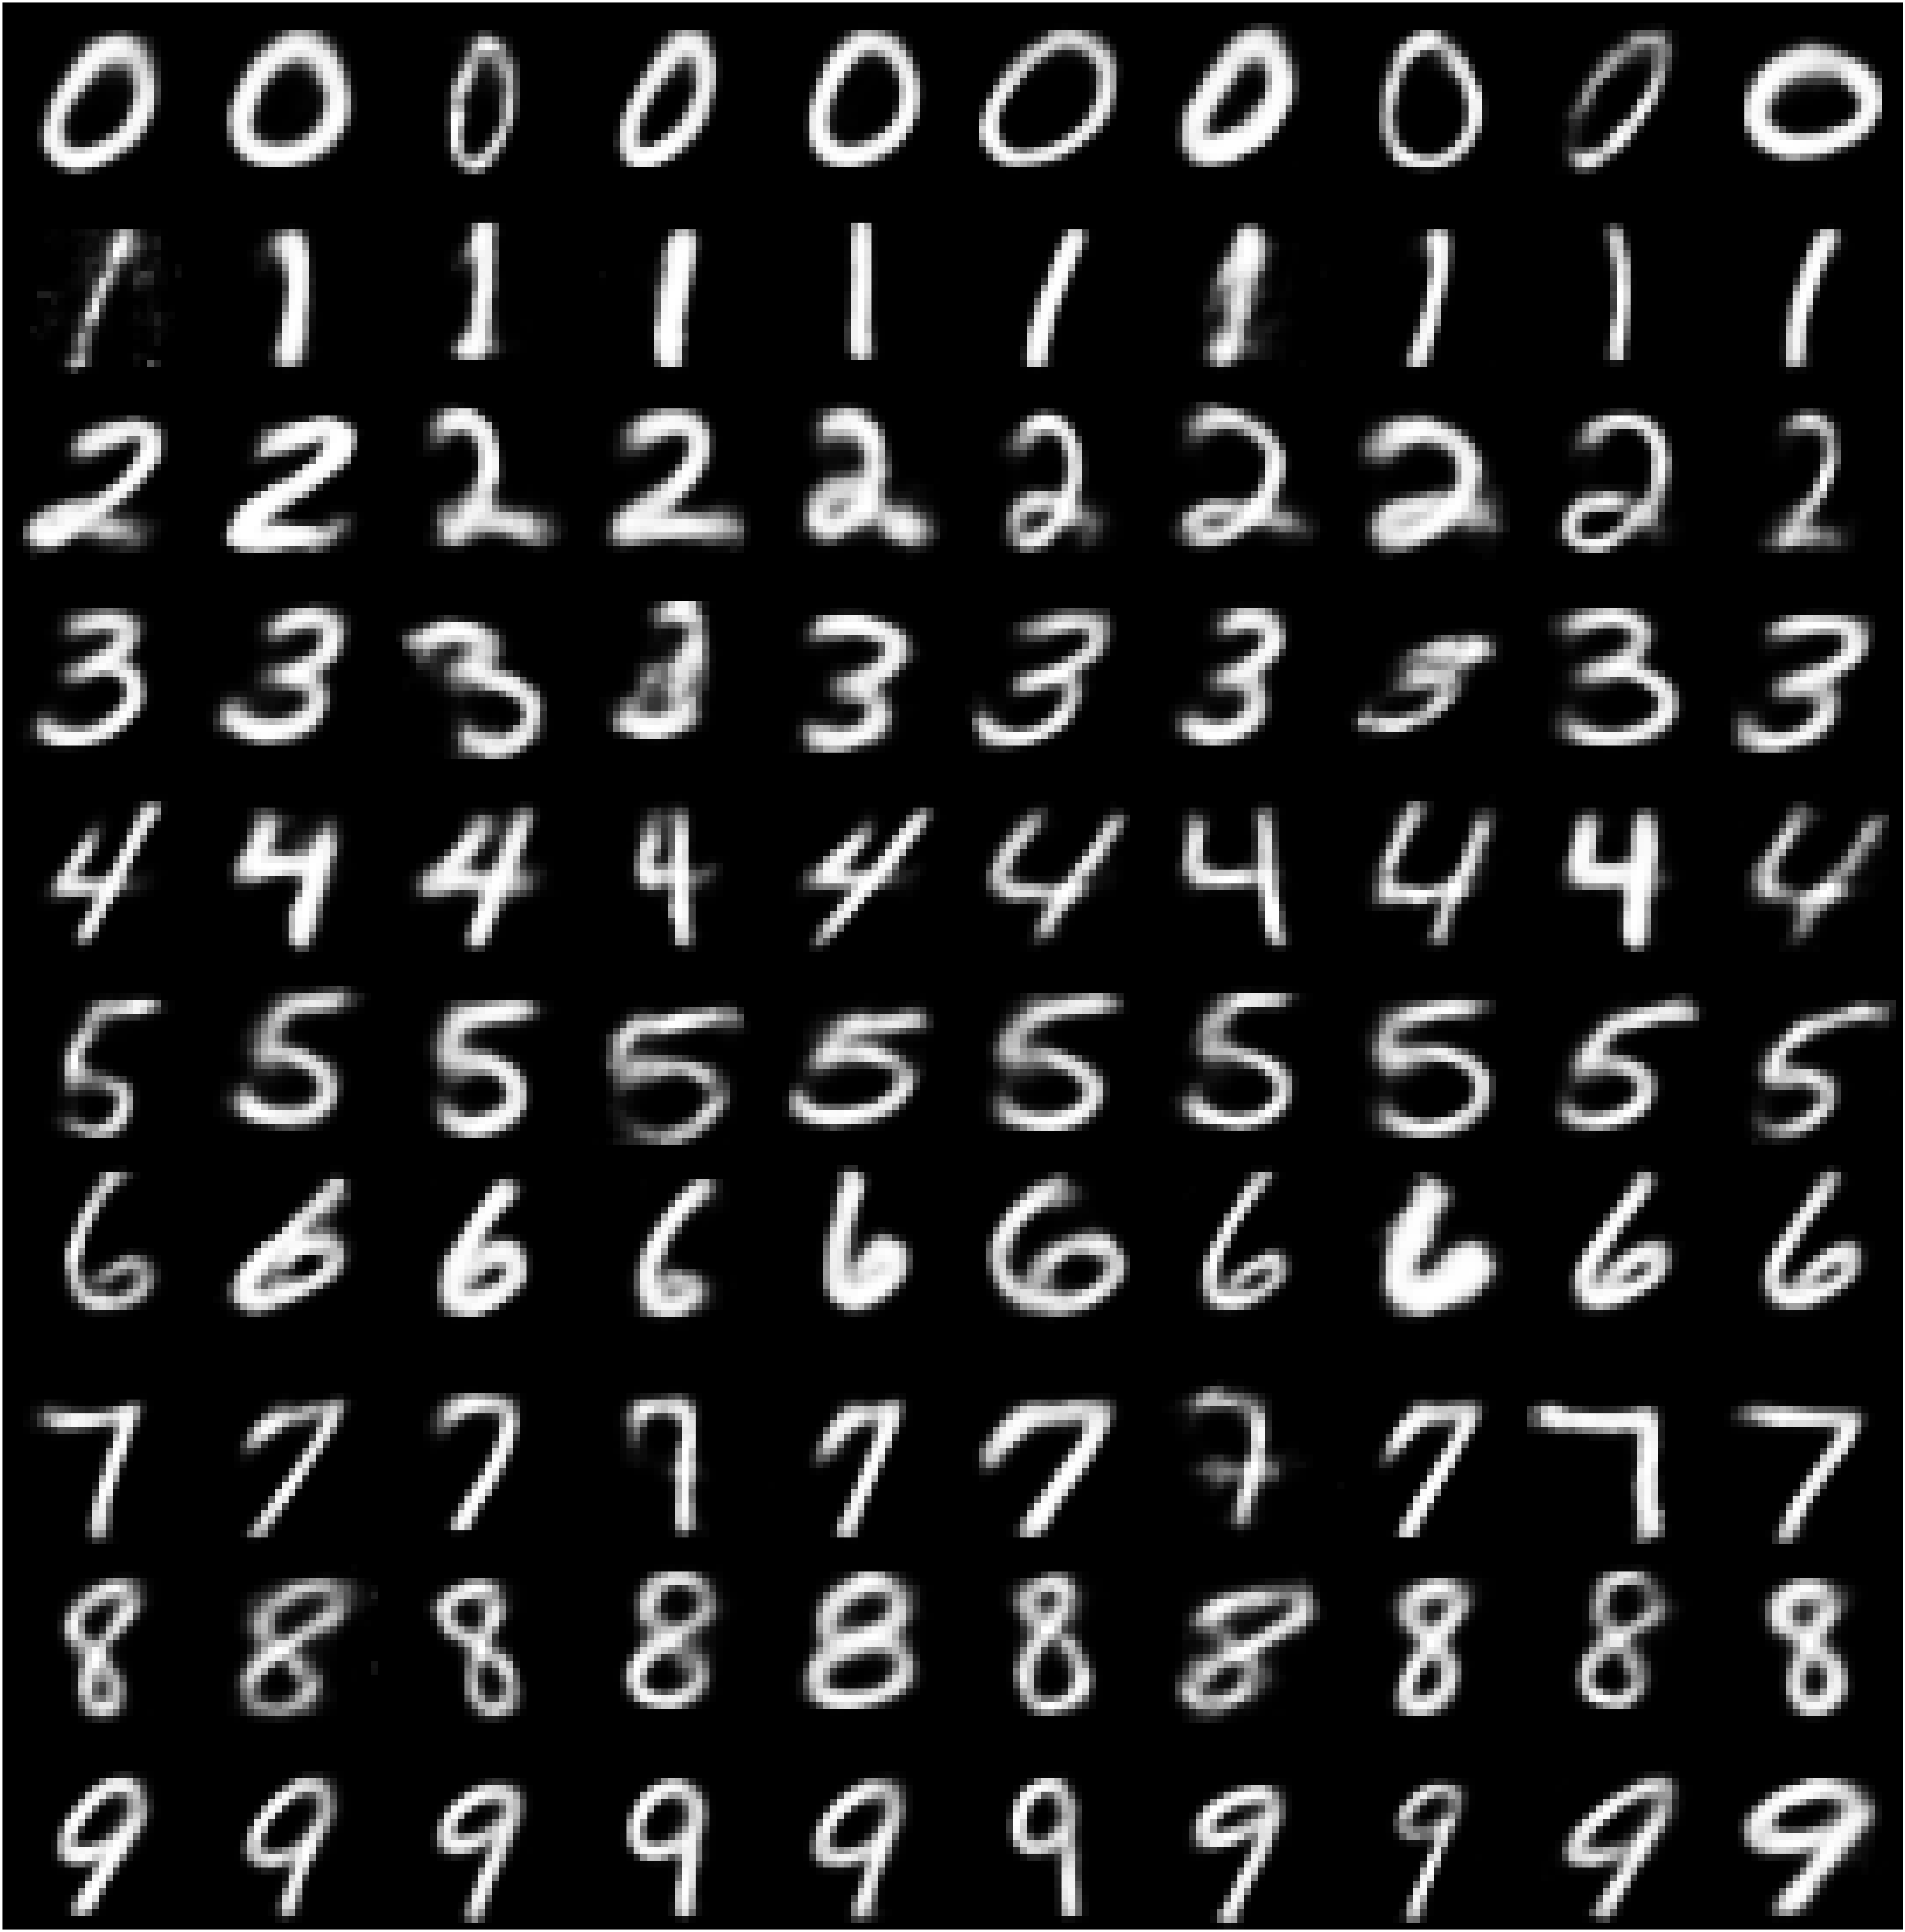

In [94]:
fig, axs = plt.subplots(10, 10, figsize=(100, 100)) # figsize(20, 20)

for row in range(10):
    for col in range(10):
        axs[row][col].imshow(X_out[row * 10 + col].reshape(28, 28), cmap="gray")
        axs[row][col].axis("off")

plt.subplots_adjust(wspace=-0.3, hspace=0)

### UMAP

In [77]:
import umap.umap_ as umap
import seaborn as sns

In [78]:
N = 1000

In [79]:
prior = torch.distributions.Normal(0, 1)
z = prior.sample((N * N_CLASSES, LATENT_DIM)).type(torch.float64)

In [81]:
Y_result = torch.tensor([i for i in range(N_CLASSES) for j in range(N)]).reshape(N * N_CLASSES, 1)

In [82]:
C_result = torch.zeros(Y_result.shape[0], N_CLASSES)
C_result.scatter_(1, Y_result, torch.ones(Y_result.shape[0], 1).type(torch.float32))

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [83]:
X_out = dec(z.to(device), C_result.to(device))
X_out = X_out.detach().numpy()

In [84]:
reducer = umap.UMAP(random_state=42)

In [85]:
embedding = reducer.fit_transform(X_out)

In [86]:
labels = np.array(Y_result).flatten()

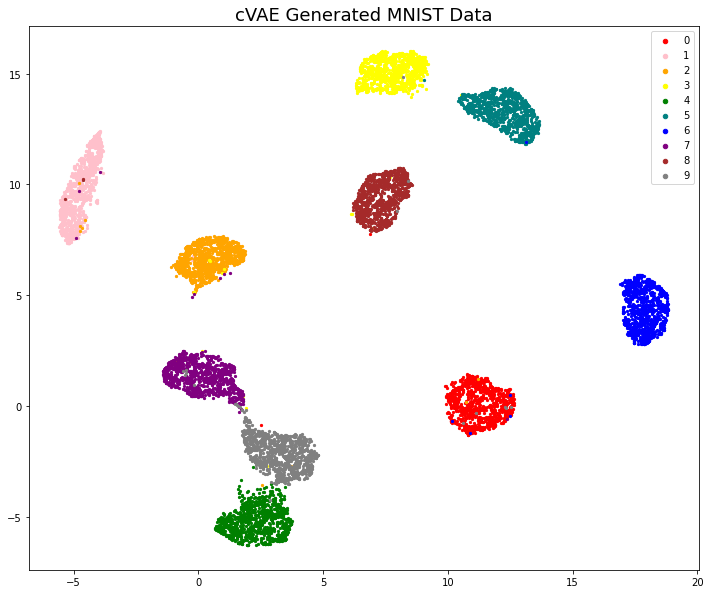

In [109]:
color = ["red", "pink", "orange", "yellow", "green", "teal", "blue", "purple", "brown", "gray"]
fig, ax = plt.subplots(figsize=(12, 10))
for i in range(10):
    indices = np.where(labels==i)[0]
    plt.scatter(embedding[indices, 0], embedding[indices, 1], s=5, label=i, color=color[i])
plt.title("cVAE Generated MNIST Data", fontsize=18)
plt.legend(markerscale=2)
plt.show()